In [61]:
import os, sys
import matplotlib.pyplot as plt 
import seaborn
import matplotlib
import numpy as np 
import math 
import matplotlib
import pandas as pd
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42


color_list = ['tab:blue',
            'tab:orange',   
            'tab:green',
            'tab:red',
            'tab:purple',
            'tab:brown',
            'tab:pink',
            'tab:gray',
            'tab:olive',
            'tab:cyan']

hatch_list = [
    '', 
    '/', 
    '\\'
    '///', 
    '--', 
    '+', 
    'x'
    '*', 
    'o', 
    'O', 
    '.'
]

line_style_list = [
    '--', 
    '-', 
    '--', 
    '-', 
]

marker_list = [
    'o',
    'o', 
    '^',
    '^', 
    'X', 
    'D'
    's', 
]

c

def autolabel_percent(rects, ax, value_list, error_list=None, str_func=None):
    if str_func is None: 
        str_func = lambda x: '%.2f'%(x)

    if error_list is None: 
        error_list = [0 for _ in value_list]

    for idx, rect in enumerate(rects):
        if value_list[idx] is None: continue
        height = rect.get_height()
        ax.annotate(str_func(value_list[idx]),
                    xy=(rect.get_x() + rect.get_width() / 2, height+error_list[idx]),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=16, fontweight='bold')


def check_before_run(**kwargs): 
    if   kwargs['full'] + kwargs['half'] + kwargs['forth'] > 1: 
        return False 
    return True 


def apply_grid(ax, **kwargs): 
    if kwargs.get('grid'): 
        if not (kwargs.get('ygrid') or kwargs.get('xgrid')): 
            ax.grid(linestyle='-.', linewidth=1, alpha=0.5)

    if kwargs.get('ygrid'): 
        ax.grid(linestyle='-.', linewidth=1, alpha=0.5, axis='y')
    if kwargs.get('xgrid'): 
        ax.grid(linestyle='-.', linewidth=1, alpha=0.5, axis='x')


def apply_spine(ax, **kwargs): 
    if kwargs.get('spines'): 
        ax.spines['right'].set_color('none')
        ax.spines['top'].set_color('none')


def apply_font(kwargs): 
    font = {'family' : 'serif',
            'size'   : 18}
    if kwargs.get('font'): 
        font.update(kwargs.get('font'))
    matplotlib.rc('font', **font)


def apply_log(ax, **kwargs): 
    if kwargs.get('logx'): 
        ax.set_xscale('log', basex=kwargs.get('logx'))
    if kwargs.get('logy') > 0: 
        ax.set_yscale('log', basey=kwargs.get('logy'))

def init_plot(ncols, **kwargs): 
    # if len(kwargs) > 0: 
    #     assert check_before_run(kwargs)
    
    apply_font(kwargs)
    fig, axes = matplotlib.pyplot.subplots(1, ncols)
    if ncols == 1: 
        axes = [axes]
    fig.set_size_inches(w=ncols* 6, h=3)

    for ax in axes: 
        apply_grid(ax, **kwargs)
        apply_spine(ax, **kwargs)
        apply_log(ax, **kwargs)

    return fig, axes 


In [62]:
def cal_jct(df): 
    num_job = 1.0 * len(df)
    jct = 0
    min_time = sys.maxsize
    max_time = 0
    jct_list = list() 
    for idx, job in df.iterrows(): 
        jct += (job.completion_time - job.submission_time) / num_job
        min_time = min(job.submission_time, min_time)
        max_time = max(job.completion_time, max_time)
        jct_list.append((job.completion_time - job.submission_time))
    return jct, max(jct_list) # max_time - min_time

def cal_fft(df): 
    unfairs = 0 
    for idx, job in df.iterrows(): 
        if job.finish_time_fairness > 1: 
            unfairs += 1
    num_job = len(df)
    return unfairs / num_job

In [63]:
def main(info_by_method, save_path): 

    fig, axes = init_plot(1, grid=True, logy=template.get('logy', 0))

    for ax in axes: 
        ckpt_list = [0, 15, 30, 45, 60, 75, 90]
        x_list = [i for i in range(len(ckpt_list))]
        for idx, info in enumerate(info_by_method): 
            model_name, jct_list, _ = info 
            ax.plot(x_list, jct_list, color=color_list[idx], linestyle=line_style_list[idx % 4], markersize=template.get('line_markersize'), marker=marker_list[idx], label=model_name, linewidth=template.get('linewidth'))

        ax.set_ylabel('Avg. JCT (Hour)', fontsize=template['fontsize'])

        # ax.spines['right'].set_visible(False)
        # ax.spines['top'].set_visible(False)
        
        ax.set_xlim(0, max(x_list))
        ax.set_yticks(np.arange(1, 2.6, 0.2))
        ax.set_ylim(1, 2.2)
        axes_list = x_list
        ax.set_xticks([val for val in axes_list])
        ax.set_xticklabels([str(val) for val in ckpt_list], fontsize=template['fontsize'], rotation=0)
        ax.set_xlabel('Context Switch Overhead (Sec)', fontsize=template['fontsize'])
    # plt.legend() 
    # fig.legend(fontsize=template['fontsize'], loc='upper center', ncol=3)
    fig.legend(fontsize=template['fontsize'], loc='upper center', ncol=2, bbox_to_anchor=(0.52, 0.9), fancybox=True, shadow=False, edgecolor="white", handlelength=1.5, columnspacing=1) 

    plt.savefig('images/ckpt/ckpt.jpg', bbox_inches='tight') 
    plt.savefig('images/ckpt/ckpt.pdf', bbox_inches='tight')
    plt.show()

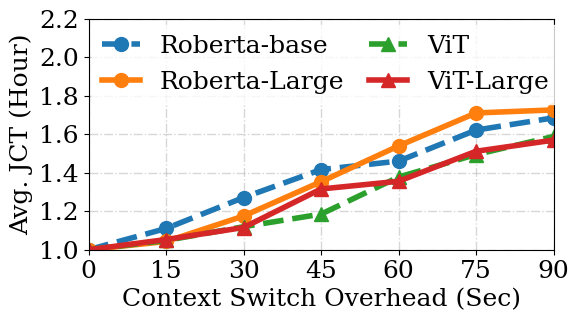

In [64]:
if True: 
    import glob 
    model_name_list = ['roberta-base',  'roberta-large', 'vit', 'vit-large']
    other_name_list = ['Roberta-base', 'Roberta-Large', 'ViT', 'ViT-Large']

    log_info = ''
    info_by_method = list() # ('titan', '-True'), 
    for model_idx, model_name in enumerate(model_name_list):

        fairness_info_by_method = list() 
        jct_list = list() 
        
        ckpt_list = [0, 15, 30, 45, 60, 75, 90]
        for ckpt in ckpt_list: 
            csv_name = os.path.join('../result/ckpt/', 'FM-1-{}'.format(model_name), str(ckpt), 'titan.csv')
            # import pdb; pdb.set_trace() 
            df = pd.read_csv(csv_name)
            jct, makespan = cal_jct(df)
            jct_list.append(jct)
        jct_list = [jct / jct_list[0] for jct in jct_list]
        info_by_method.append((other_name_list[model_idx], jct_list, [0 for jct in jct_list]))

    template.update(
        {
            "norm": False, 
            "width": 0.3, 
            "autolabel": False, 
            'norm': True,
            'logy': 0,
            'barh': False,
        }
    )

    main(info_by_method=info_by_method, save_path='plot/images/ckpt/ckpt.jpg')